# **Top Three models are:** 
### _**a) Logit**_
### _**b) Balanced Random Forest**_
### _**c) Decision Tree**_

In [829]:
from iexfinance.stocks import Stock
import pandas as pd
import numpy as np
from pathlib import Path
from newsapi.newsapi_client import NewsApiClient
import ipywidgets as widgets
from IPython.display import display
from datetime import date, datetime, timedelta
import os 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from iexfinance.stocks import get_historical_data
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [830]:
import os
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
from path import Path
%matplotlib inline
from datetime import datetime as dt
from dateutil.tz import gettz
import re
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import keras
from newsapi import NewsApiClient
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from pathlib import Path
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [831]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [832]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ava/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [833]:
def create_df(ticker, lag=0):
    
    sp500_csv = Path("../../project_code/Data/sp500_constituents.csv")
    sp500_df = pd.read_csv(sp500_csv)
    sp500_df['Ticker'] = sp500_df['Symbol']
    sp500_df.drop(columns='Sector',inplace=True)
    sp500_df.set_index('Ticker', inplace=True)
    
    stock_dict = sp500_df.T.to_dict('list')
    
    from datetime import date, datetime, timedelta
    newsapi = NewsApiClient(api_key=os.environ["NEWS_API_KEY"])
    pickle.dump(newsapi,open('newsapi.pickle','wb'))
    current_date = date.today()
    past_date = date.today() - timedelta(days=30)
    
    def get_headlines(keyword):
        all_headlines = []  #empty list for all headlines
        all_dates = [] #empyt list for all dates
        date = current_date #today's date
        #print(f"Fetching news about '{keyword}'") #prints single string of function starting
        #print("*" * 30) #creating a line of stars for readability
        while date > past_date: #establishes length of dates being pulled by for the 
            #lenght of the difference between today and past_date 
            #print(f"retrieving news from: {date}")#printing string for loop readability  
            articles = newsapi.get_everything(   #pulling articles through API
                q=keyword,
                from_param=str(date),
                to=str(date),
                language="en",
                sort_by="relevancy",
                page=1,
            )
            headlines = []
            for i in range(0, len(articles["articles"])):

                #pulling the content part of the dict
                headlines.append(articles["articles"][i]["content"])
            all_headlines.append(headlines)
            all_dates.append(date)
            date = date - timedelta(days=1) #moving through the days            
        return all_headlines, all_dates
    
    headlines, dates = get_headlines(stock_dict[ticker][1])
    
    df = pd.DataFrame(headlines)
    df.index = pd.to_datetime(dates)
    
    concatinated_list = []
    i = 0
    while i < len(df):
        date = df.index[i]
        daily_data = df.iloc[i,:].dropna().to_list()
        daily_data = "".join(daily_data)
        concatinated_list.append({"Date":date,
                                  "articles":daily_data
                                  })
        i = i + 1
        
    df = pd.DataFrame(concatinated_list)
    lemmatizer = WordNetLemmatizer()
    
    def tokenizer(text):
        sw = set(stopwords.words('english'))
        regex = re.compile("[^a-zA-Z ]")
        re_clean = regex.sub('', text)
        words = word_tokenize(re_clean)
        lem = [lemmatizer.lemmatize(word) for word in words]
        tokens = [word.lower() for word in lem if word.lower() not in sw]

        return tokens

    df["tokens"] = [tokenizer(i) for i in df["articles"]]
    df["Clean Words"] = [" ".join(i)for i in df["tokens"]]
    
    def get_sentiment(dataframe):
    # list of sentiment objects observed
        df_sentiments = []
        i = 0 
        # for rows in df: # the next time you put a for-loop outside of a try fn 
        # there will be a muckduck
        # for loops are used for interating through one object ie. for every item in list 
        # while loops can be used for interating through multiple objects on the same 
        # index ie. 1st item in ...for 2nd item in... for 3rd item in.. 


        while i < len(dataframe["Clean Words"]): # if we did len of df, then it would be 
            # the length of columns by doing len of df[col], then its length of rows

            # to get values for the sentiment parameters
            text = dataframe["Clean Words"][i] 
            date = dataframe["Date"][i]

            # activate sentiment analysis
            sentiment = analyzer.polarity_scores(text)  ## Attribute Error is applied for 
                                                        ## NoneTypes in 
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]

            # append results of sentiment analysis per row of sentiment parameters df
            df_sentiments.append({
                    "text": text,
                    "date": date,
                    "compound": compound,
                    "positive": pos,
                    "negative": neg,
                    "neutral": neu
                })
            i += 1

        # Create DataFrame
        final_df = pd.DataFrame(df_sentiments)

        # Reorder DataFrame columns
        cols = ["date", "text", "compound", "positive", "negative", "neutral"]
        final_list = final_df[cols]

        return final_list

    df = get_sentiment(df)
    df = df.set_index('date')
    df = df.sort_values(by='date',ascending=True)

    # setting start and end date for the past four weeks
    # 29 days needed instead of 28 days so that we get 28 days of return when we calculate
    end_date_stock = datetime.now()
    start_date_stock = end_date_stock + timedelta(-31)

    # getting data from the API and adding to DataFrame
    returns_df = get_historical_data(ticker, start_date_stock, end_date_stock,  
                                     output_format='pandas')
    returns_df.drop(columns=['open','high','low','volume'],inplace=True)
    returns_df = returns_df.pct_change() * 100
    returns_df.dropna(inplace=True)
    returns_df.isnull().sum()
    returns_df.rename(columns={'close':'return'}, inplace=True)
    
    combined_df = pd.concat([df, returns_df], axis=1)

    # Function takes in an NLP/stock returns dataframe and calculates the average polarity
    # scores over non-trading days and replaces scores of the first trading day after
    # non-trading days with average score of previous days.
    def cleaned_df(dataframe):
        compound = []
        positive = []
        negative = []
        neutral = []

        for index, row in dataframe.iterrows():

            # If daily return is null value for a given day, append polarity scores to their
            # respective lists.
            if pd.isnull(row['return']):
                compound.append(row['compound'])
                positive.append(row['positive'])
                negative.append(row['negative'])
                neutral.append(row['neutral'])
                dataframe.drop(index=index, inplace=True)

            elif pd.notnull(row['return']):
                
                # The list of compound polarity scores will be empty if the stock was traded
                # on the previous day; therefore, move along.
                if len(compound) == 0:
                    pass

                # If the list is not empty, then at least one day prior was a non-trading 
                # day. Append the current day's scores to the list and calculate the mean 
                # for each score. Then replace the current day's polarity scores with the 
                # average scores of today and previous non-trading days.
                else:
                    compound.append(row['compound'])
                    compound_mean = np.mean(compound)
                    compound = []

                    positive.append(row['positive'])
                    positive_mean = np.mean(positive)
                    positive = []

                    negative.append(row['negative'])
                    negative_mean = np.mean(negative)
                    negative = []

                    neutral.append(row['neutral'])
                    neutral_mean = np.mean(neutral)
                    neutral = []

                    dataframe.at[index, 'compound'] = compound_mean
                    dataframe.at[index, 'positive'] = positive_mean
                    dataframe.at[index, 'negative'] = negative_mean
                    dataframe.at[index, 'neutral'] = neutral_mean

            else:
                pass

        return dataframe.sort_index(ascending=True)
    
    # Shift the return column up to adjust for a lag in stock reaction to sentiments.
    final_df = cleaned_df(combined_df)
    final_df['return'] = final_df['return'].shift(-lag)
    final_df.dropna(inplace=True)
    
    return final_df

In [834]:
ticker = 'DIS'

In [835]:
#dis_df = create_df('DIS')

In [836]:
dis_df.head(10)

,text,compound,positive,negative,neutral,return,return_sign
date,,,,,,,
2020-03-19,health worker screen patient coronavirus march...,0.985100,0.117000,0.044,0.839000,6.903153,1.0
2020-03-20,disney said friday postponing launch eponymous...,0.898800,0.106000,0.090,0.804000,-9.428000,-1.0
2020-03-23,health worker screen patient coronavirus march...,0.970400,0.125667,0.071,0.803333,-0.255873,-1.0
2020-03-24,disney streaming service walt disney company h...,0.996800,0.192000,0.047,0.761000,14.412313,1.0
2020-03-25,response coronavirus pandemic disney theme par...,0.995300,0.182000,0.050,0.768000,2.660008,1.0
2020-03-26,authors note article part series attempt ident...,0.998700,0.239000,0.020,0.741000,4.596446,1.0
2020-03-27,disneyland walt disney world initially planned...,0.988600,0.114000,0.033,0.853000,-8.504176,-1.0
2020-03-30,enjoying killer queen blacki started playing k...,0.994267,0.157000,0.049,0.794333,3.526971,1.0
2020-03-31,walt disneynysedis taking step conserve cash c...,0.982100,0.122000,0.058,0.821000,-3.206413,-1.0


In [837]:
# dis_df.to_pickle(f'../Data/{ticker}_sent_return.pickle')

In [838]:
# Just lag function
def df_lag(df, lag=0):
    df['return'] = df['return'].shift(-lag)
    df.dropna(inplace=True)
    
    return df

In [839]:
df = df_lag(dis_df)

In [840]:
df['return_sign'] = np.sign(df['return'].values)
df_class = df.copy() # save a clean copy 

In [841]:
df.head()

,text,compound,positive,negative,neutral,return,return_sign
date,,,,,,,
2020-03-19,health worker screen patient coronavirus march...,0.9851,0.117000,0.044,0.839000,6.903153,1.0
2020-03-20,disney said friday postponing launch eponymous...,0.8988,0.106000,0.090,0.804000,-9.428000,-1.0
2020-03-23,health worker screen patient coronavirus march...,0.9704,0.125667,0.071,0.803333,-0.255873,-1.0
2020-03-24,disney streaming service walt disney company h...,0.9968,0.192000,0.047,0.761000,14.412313,1.0
2020-03-25,response coronavirus pandemic disney theme par...,0.9953,0.182000,0.050,0.768000,2.660008,1.0


In [842]:
df = df.drop(columns=['text'])
df

,compound,positive,negative,neutral,return,return_sign
date,,,,,,
2020-03-19,0.985100,0.117000,0.04400,0.839000,6.903153,1.0
2020-03-20,0.898800,0.106000,0.09000,0.804000,-9.428000,-1.0
2020-03-23,0.970400,0.125667,0.07100,0.803333,-0.255873,-1.0
2020-03-24,0.996800,0.192000,0.04700,0.761000,14.412313,1.0
2020-03-25,0.995300,0.182000,0.05000,0.768000,2.660008,1.0
2020-03-26,0.998700,0.239000,0.02000,0.741000,4.596446,1.0
2020-03-27,0.988600,0.114000,0.03300,0.853000,-8.504176,-1.0
2020-03-30,0.994267,0.157000,0.04900,0.794333,3.526971,1.0
2020-03-31,0.982100,0.122000,0.05800,0.821000,-3.206413,-1.0


In [843]:
#df.to_pickle(f'../Data/{ticker}_clean.pickle')

In [844]:
df = pd.read_pickle('../Data/DIS_clean.pickle')

In [845]:
X = df.drop(columns=['return', 'return_sign'])
X.head()

,compound,positive,negative,neutral
date,,,,
2020-03-18,0.9978,0.183000,0.015,0.802000
2020-03-19,0.9851,0.117000,0.044,0.839000
2020-03-20,0.8988,0.106000,0.090,0.804000
2020-03-23,0.9704,0.125667,0.071,0.803333
2020-03-24,0.9968,0.192000,0.047,0.761000


In [846]:
y = df['return_sign']

In [847]:
y = y.to_frame()
y.head()

,return_sign
date,
2020-03-18,-1.0
2020-03-19,1.0
2020-03-20,-1.0
2020-03-23,-1.0
2020-03-24,1.0


In [848]:
ticker = 'DIS'

In [849]:
# 3-layer Neural Net

In [850]:
# Create the features (X) and target (y) sets
X = df.iloc[:, 0:4].values
y = df["return_sign"].values

In [851]:
y= y.reshape(-1,1)
y.shape

(20, 1)

In [852]:
X.shape

(20, 4)

In [853]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [854]:
# Creating training and testing data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False, random_state=42) 

In [855]:
# ---- Could load a saved model alternatively ------

from keras.models import load_model
import tensorflow as tf
from tensorflow import keras

# returns a compiled model
# identical to the previous one
nn_3 = tf.keras.models.load_model('../Models/../Models/disney_nn_loss_3_layers.h5')

In [856]:
# Creating validation data sets
from sklearn.model_selection import train_test_split
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False, random_state=42) 

In [860]:
# Define the model - deep neural net
#number_input_features = 4
#hidden_nodes_layer1 = 12
#hidden_nodes_layer2 = 8
#hidden_nodes_layer3 = 3


#nn = Sequential()
# First hidden layer
#nn.add(
#    Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
#)
# Second hidden layer
#nn.add(Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
#nn.add(Dense(units=hidden_nodes_layer3, activation="tanh"))

# Output layer
#nn.add(Dense(units=1, activation="linear"))

In [858]:
# Compile model
#nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
#nn.summary()

In [859]:
model_3 = nn_3.fit(X_train_val, y_train_val, batch_size=1, validation_data=(X_val, y_val), shuffle=False, epochs=200)

Train on 9 samples, validate on 5 samples
Epoch 1/200
9/9 [==============================] - 0s 33ms/sample - loss: 1.1068 - mse: 1.1068 - val_loss: 1.2858 - val_mse: 1.2858
Epoch 2/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.9934 - mse: 0.9934 - val_loss: 1.2151 - val_mse: 1.2151
Epoch 3/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.8842 - mse: 0.8842 - val_loss: 1.1609 - val_mse: 1.1609
Epoch 4/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.7943 - mse: 0.7943 - val_loss: 1.1233 - val_mse: 1.1233
Epoch 5/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.7235 - mse: 0.7235 - val_loss: 1.0990 - val_mse: 1.0990
Epoch 6/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.6680 - mse: 0.6680 - val_loss: 1.0852 - val_mse: 1.0852
Epoch 7/200
9/9 [==============================] - 0s 2ms/sample - loss: 0.6225 - mse: 0.6225 - val_loss: 1.0762 - val_mse: 1.0762
Epoch 8/200
9/9 [=======================

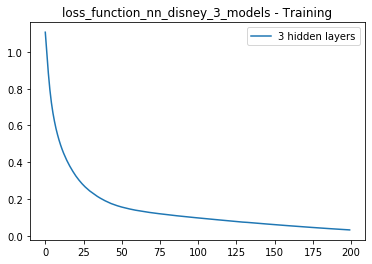

In [861]:
plt.plot(model_3.history["loss"])

plt.title("loss_function_nn_disney_3_models - Training")
plt.legend(["3 hidden layers"])
plt.savefig(f'../Images/loss_function_nn_{ticker}_3layers.png')
plt.show()

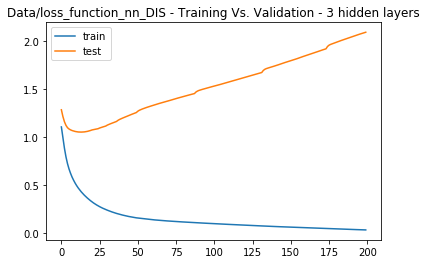

In [862]:
# Train vs test for deep net
plt.plot(model_3.history["loss"])
plt.plot(model_3.history["val_loss"])
plt.title(f"Data/loss_function_nn_{ticker} - Training Vs. Validation - 3 hidden layers")
plt.legend(["train", "test"])
plt.savefig(f'../Images/loss_function_nn_{ticker}_train_val_3layer.png')
plt.show()

#### _**Logit Model**_
_**Model of Best Fit**_

In [863]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [864]:
# Create the features (X) and target (y) sets
X = df.iloc[:, 0:4]
y = df["return_sign"]

In [865]:
y.shape

(20,)

In [866]:
# Creating training and testing data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False, random_state=42) 

In [867]:
#Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

# Scale the training data - only scale X_train and X_test data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [868]:
# ********* MODEL FITTING *************

   # --------- Loigt -----------
   # --------Start-------------
   
M = 'Logit'
        
from sklearn import linear_model 

lm = linear_model.LogisticRegression(C = 1e5)
lm

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [869]:
lm.fit(X_train, y_train)

   # --------- Logit ------------
   # ---------End -------------

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [870]:
lm_pred = lm.predict(X_test)

In [871]:
# Score the accuracy
print("Training vs. Testing - Logit")
print(f"Training Data Score: {lm.score(X_train, y_train):,.04f}")
print(f"Testing Data Score: {lm.score(X_test, y_test):,.04f}")

Training vs. Testing - Logit
Training Data Score: 0.7857
Testing Data Score: 0.6667


In [872]:
#Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

print("Balanced Accuracy Score - Logit")
balanced_accuracy_score(y_test, lm_pred)

Balanced Accuracy Score - Logit


0.6666666666666666

In [873]:
print("Confusion Matrix - Logit")
confusion_matrix(y_test, lm_pred)

Confusion Matrix - Logit


array([[1, 2],
       [0, 3]])

In [874]:
from sklearn.metrics import classification_report

print("Classification Report - Logit")
print(classification_report(y_test, lm_pred))

Classification Report - Logit
              precision    recall  f1-score   support

        -1.0       1.00      0.33      0.50         3
         1.0       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



In [875]:
# Evaluating the Logit model in a nicer format

# Calculating the confusion matrix
cm_lm = confusion_matrix(y_test, lm_pred)
cm_lm_df = pd.DataFrame(
    cm_lm, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"]
)

# Calculating the accuracy score
acc_lm_score = balanced_accuracy_score(y_test, lm_pred)

In [876]:
# Displaying results
print("Confusion Matrix - Logit")
display(cm_lm_df)
print(f"Balanced Accuracy Score : {acc_lm_score:,.04f}")
print("Classification Report - Logit")
print(classification_report(y_test, lm_pred))

Confusion Matrix - Logit


,Predicted -1,Predicted 1
Actual -1,1,2
Actual 1,0,3


Balanced Accuracy Score : 0.6667
Classification Report - Logit
              precision    recall  f1-score   support

        -1.0       1.00      0.33      0.50         3
         1.0       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



### _SVM_

In [877]:
# Create the features (X) and target (y) sets
X = df.iloc[:, 0:4]
y = df["return_sign"]

In [878]:
# Creating training and testing data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False, random_state=42) 

In [879]:
#Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

# Scale the training data - only scale X_train and X_test data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [880]:
# ********* MODEL FITTING *************

# --------- SVM -----------
# --------Start-------------
   
M = 'SVM'
    
from sklearn.svm import SVC
    
svm = SVC(C= 1e5, probability=True)
svm

SVC(C=100000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [881]:
svc_pred = svm.fit(X_train, y_train)

In [882]:
# Score the accuracy
print("Training vs. Testing - SVM")
print(f"Training Data Score: {svm.score(X_train, y_train):,.04f}")
print(f"Testing Data Score: {svm.score(X_test, y_test):,.04f}")

Training vs. Testing - SVM
Training Data Score: 0.7857
Testing Data Score: 0.6667


### _Decision Tree_

In [883]:
# Create the features (X) and target (y) sets
X = df.iloc[:, 0:4]
y = df["return_sign"]

In [884]:
# Creating training and testing data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False) 

In [885]:
#Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

# Scale the training data - only scale X_train and X_test data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [886]:
# Creating the decision tree classifier instance
model_tree = tree.DecisionTreeClassifier()

# Fitting the model
model_tree = model_tree.fit(X_train, y_train)

# Making predictions using the testing data
tree_pred = model_tree.predict(X_test)

In [887]:
# Score the accuracy
print("Training vs. Testing - Decision Tree")
print(f"Training Data Score: {model_tree.score(X_train, y_train):,.04f}")
print(f"Testing Data Score: {model_tree.score(X_test, y_test):,.04f}")

Training vs. Testing - Decision Tree
Training Data Score: 1.0000
Testing Data Score: 0.6667


In [888]:
# Evaluating the decision tree model

# Calculating the confusion matrix
cm = confusion_matrix(y_test, tree_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, tree_pred)

In [889]:
# Displaying results
print("Confusion Matrix - Decision Tree")
display(cm_df)
print(f"Accuracy Score : {acc_score:,.04f}")
print("Classification Report - Decision Tree")
print(classification_report(y_test, tree_pred))

Confusion Matrix - Decision Tree


,Predicted -1,Predicted 1
Actual -1,1,2
Actual 1,0,3


Accuracy Score : 0.6667
Classification Report - Decision Tree
              precision    recall  f1-score   support

        -1.0       1.00      0.33      0.50         3
         1.0       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



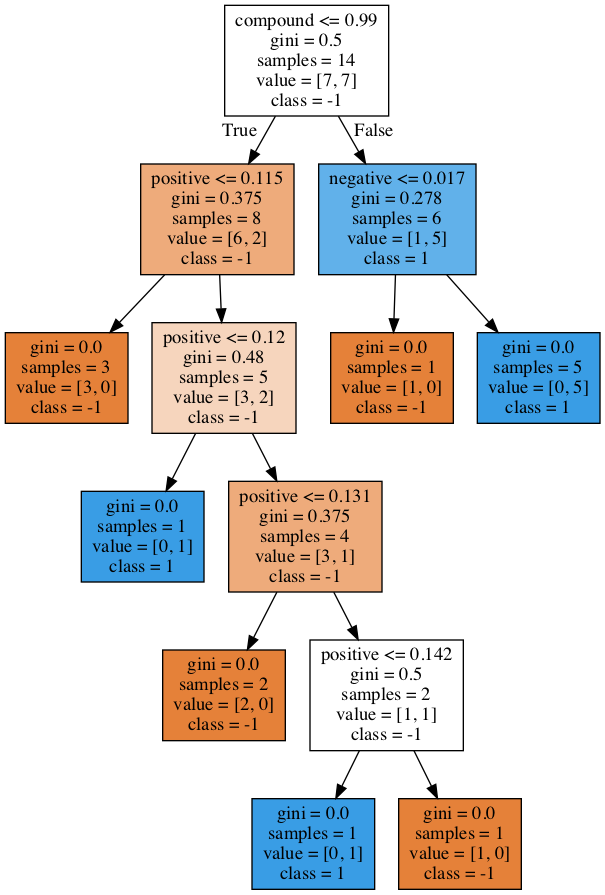

In [890]:
# Tree Visualization

# Graph tree
from sklearn import tree

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

# Create DOT data
dot_data = tree.export_graphviz(
    model_tree, out_file=None, feature_names=X.columns, class_names=["-1", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [891]:
training_window = 1

In [892]:
# Saving the tree as PDF
graph.write_pdf(f"../Images/{ticker}_{training_window}d_decision_tree_updated.pdf")

# Saving the tree as PNG
graph.write_png(f"../Images/{ticker}_{training_window}d_decision_tree_updated.png")

True

## _Ensemble Learning_

In [893]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

_**Balanced Random Forest Classifier**_

In [894]:
# Resample the training data with the RandomOversampler
# fit Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=2, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=None, oob_score=False, random_state=42,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [895]:
brf_pred = brf.predict(X_test)

balanced_accuracy_score(y_test, brf_pred)

0.6666666666666666

In [896]:
# Score the accuracy
print("Training vs. Testing - Balanced Random Forest")
print(f"Training Data Score: {brf.score(X_train, y_train):,.04f}")
print(f"Testing Data Score: {brf.score(X_test, y_test):,.04f}")

Training vs. Testing - Balanced Random Forest
Training Data Score: 0.8571
Testing Data Score: 0.6667


In [897]:
# Display the confusion matrix
print("Confusion Matrix - Balanced Random Forest")
confusion_matrix(y_test, brf_pred)

Confusion Matrix - Balanced Random Forest


array([[1, 2],
       [0, 3]])

In [898]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Classification Report - Balanced Random Forest on Imbalanced Data")
print(classification_report_imbalanced(y_test, brf_pred))

Classification Report - Balanced Random Forest on Imbalanced Data
                   pre       rec       spe        f1       geo       iba       sup

       -1.0       1.00      0.33      1.00      0.50      0.58      0.31         3
        1.0       0.60      1.00      0.33      0.75      0.58      0.36         3

avg / total       0.80      0.67      0.67      0.62      0.58      0.33         6



In [899]:
# Evaluating the Balanced Random Forest model in a nicer format

# Calculating the confusion matrix
cm_brf = confusion_matrix(y_test, brf_pred)
cm_brf_df = pd.DataFrame(
    cm_brf, index=["Actual -1", "Actual 1"], columns=["Predicted -1", "Predicted 1"]
)

# Calculating the accuracy score
acc_brf_score = accuracy_score(y_test, brf_pred)

In [900]:
# Displaying results
print("Confusion Matrix - Balanced Random Forest")
display(cm_brf_df)
print(f"Accuracy Score : {acc_brf_score:,.04f}")
print("Classification Report - Balaced Random Forest")
print(classification_report(y_test, brf_pred))

Confusion Matrix - Balanced Random Forest


,Predicted -1,Predicted 1
Actual -1,1,2
Actual 1,0,3


Accuracy Score : 0.6667
Classification Report - Balaced Random Forest
              precision    recall  f1-score   support

        -1.0       1.00      0.33      0.50         3
         1.0       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



_**Easy Ensemble AdaBoost Classifier**_

In [901]:
from imblearn.ensemble import EasyEnsembleClassifier
adb = EasyEnsembleClassifier(n_estimators=100, random_state=42)
adb.fit(X_train, y_train)

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=None,
                       random_state=42, replacement=False,
                       sampling_strategy='auto', verbose=0, warm_start=False)

In [902]:
# Calculated the balanced accuracy score
adb_pred = adb.predict(X_test)
balanced_accuracy_score(y_test, adb_pred)

0.3333333333333333

In [903]:
# Display the confusion matrix
print("Confusion Matrix - Easy Emsemble AdaBoost")
confusion_matrix(y_test, adb_pred)

Confusion Matrix - Easy Emsemble AdaBoost


array([[1, 2],
       [2, 1]])

In [904]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print("Classification Report - Easy Ensemble AdaBoost on Imbalanced Data")
print(classification_report_imbalanced(y_test, adb_pred))

Classification Report - Easy Ensemble AdaBoost on Imbalanced Data
                   pre       rec       spe        f1       geo       iba       sup

       -1.0       0.33      0.33      0.33      0.33      0.33      0.11         3
        1.0       0.33      0.33      0.33      0.33      0.33      0.11         3

avg / total       0.33      0.33      0.33      0.33      0.33      0.11         6



_**Gradient Boosting Classifier**_

In [905]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=4,
                                            max_depth=3,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train.values, y_train.ravel())
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test,
            y_test.ravel())))
    print()

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.500

Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.333

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.500

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.500

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.667

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.500



In [906]:
# Learning rates produces identical outcome
#Use learning_rate of 0.75 for it is higher compared to the rest

classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.05,
                                        max_features=4,
                                        max_depth=3,
                                        random_state=42)

# Fit the model
classifier.fit(X_train, y_train.ravel())

# Make Prediction
grad_pred = classifier.predict(X_test)
pd.DataFrame({"Prediction": grad_pred, "Actual": y_test.ravel()}).head(20)

,Prediction,Actual
0,1.0,1.0
1,-1.0,-1.0
2,-1.0,1.0
3,1.0,-1.0
4,1.0,1.0
5,1.0,-1.0


In [907]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, grad_pred)
print(f"Accuracy Score : {acc_score}")

Accuracy Score : 0.5


In [908]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, grad_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
print("Confusion Matrix - Gradient Boosting")
display(cm_df)

Confusion Matrix - Gradient Boosting


,Predicted 0,Predicted 1
Actual 0,1,2
Actual 1,1,2


In [909]:
# Generate classification report
print("Classification Report - Gradient Boosting on Imbalanced Data")
print(classification_report_imbalanced(y_test, grad_pred))

Classification Report - Gradient Boosting on Imbalanced Data
                   pre       rec       spe        f1       geo       iba       sup

       -1.0       0.50      0.33      0.67      0.40      0.47      0.21         3
        1.0       0.50      0.67      0.33      0.57      0.47      0.23         3

avg / total       0.50      0.50      0.50      0.49      0.47      0.22         6



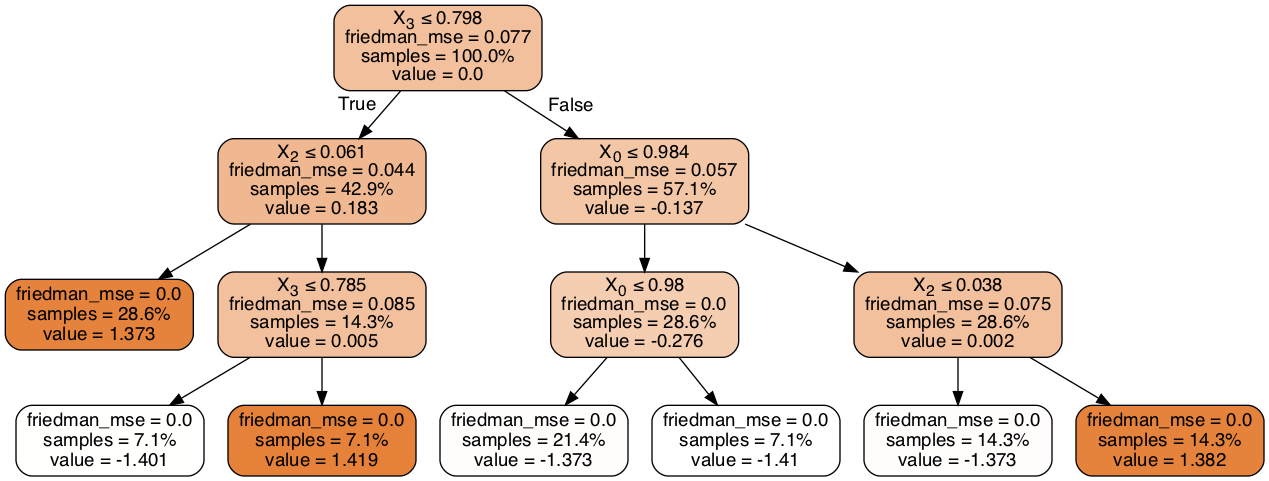

In [910]:
# Graph tree
from sklearn import tree

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(
    classifier.estimators_[12, 0],
    out_file=None, filled=True,
    rounded=True,
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [911]:
# Saving the tree as PDF
graph.write_pdf(f"../Images/{ticker}_GradientBoosting_tree_{training_window}_updated.pdf")

# Saving the tree as PNG
graph.write_png(f"../Images/{ticker}_GradientBoosting_tree_{training_window}_updated.png")

True

In [912]:
# Plot the Precision Recall Curvey for both the SMOTEENN + Logistic Regression model
# and the Balanced Random Forest model
from sklearn.metrics import precision_recall_curve

probs_brf = brf.predict_proba(X_test)[:, 1]
probs_adb = adb.predict_proba(X_test)[:, 1]
probs_grad = classifier.predict_proba(X_test)[:, 1]

precision_brf, recall_brf, _ = precision_recall_curve(y_test, probs_brf, pos_label=1)
precision_adb, recall_adb, _ = precision_recall_curve(y_test, probs_adb, pos_label=1)
precision_grad, recall_grad, _ = precision_recall_curve(y_test, probs_grad, pos_label=1)

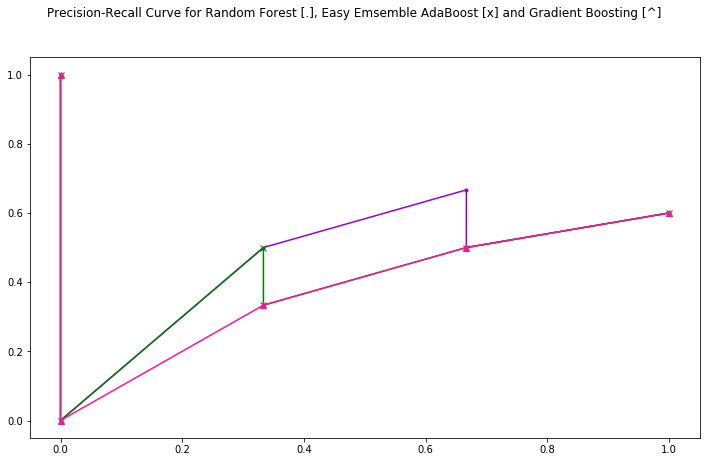

In [913]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,7))

plt.plot(recall_brf, precision_brf, marker='.', color='darkviolet')
plt.plot(recall_adb, precision_adb, marker='x', color='green')
plt.plot(recall_grad, precision_grad, marker='^', color='deeppink')

plt.suptitle('Precision-Recall Curve for Random Forest [.], Easy Emsemble AdaBoost [x] and Gradient Boosting [^]')
plt.show()

In [914]:
# Saving the tree as PDF
graph.write_pdf(f"../Images/pr_curve_brf_adb_grad_{ticker}_{training_window}d_updated.pdf")

# Saving the tree as PNG
graph.write_png(f"../Images/pr_curve_brf_adb_grad_{ticker}_{training_window}d_updated.png")

True